<a id='Top'></a>

# Prepare clinical data <a class='tocSkip'></a>

Preprocess clinical data for all patients, collect relevant survival labels and define train/validation/test split using the unique patient ID codes.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import os

import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from lifelines import KaplanMeierFitter

In [2]:
DATA_LOCATION = '/mnt/data/Processed_Data/Clinical'

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-and-explore-data" data-toc-modified-id="Load-and-explore-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load and explore data</a></span></li><li><span><a href="#Select-variables" data-toc-modified-id="Select-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Select variables</a></span></li><li><span><a href="#Clean-up-inconsistencies" data-toc-modified-id="Clean-up-inconsistencies-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clean up inconsistencies</a></span><ul class="toc-item"><li><span><a href="#Consolidate-race-and-ethnicity" data-toc-modified-id="Consolidate-race-and-ethnicity-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Consolidate <code>race</code> and <code>ethnicity</code></a></span></li><li><span><a href="#Missing-label-data" data-toc-modified-id="Missing-label-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Missing label data</a></span><ul class="toc-item"><li><span><a href="#vital_status" data-toc-modified-id="vital_status-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span><code>vital_status</code></a></span></li><li><span><a href="#Both-duration-values" data-toc-modified-id="Both-duration-values-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Both duration values</a></span></li><li><span><a href="#Required-duration-value" data-toc-modified-id="Required-duration-value-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Required duration value</a></span></li></ul></li><li><span><a href="#Not-missing-days_to_last_follow_up-when-vital_status-is-&quot;Dead&quot;" data-toc-modified-id="Not-missing-days_to_last_follow_up-when-vital_status-is-&quot;Dead&quot;-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Not missing <code>days_to_last_follow_up</code> when <code>vital_status</code> is "Dead"</a></span></li><li><span><a href="#Negative-durations" data-toc-modified-id="Negative-durations-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Negative durations</a></span></li></ul></li><li><span><a href="#Label-data" data-toc-modified-id="Label-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Label data</a></span></li><li><span><a href="#Train-val-test-split" data-toc-modified-id="Train-val-test-split-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train-val-test split</a></span><ul class="toc-item"><li><span><a href="#Survival-curves" data-toc-modified-id="Survival-curves-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Survival curves</a></span></li></ul></li><li><span><a href="#Save-clinical-data-to-file" data-toc-modified-id="Save-clinical-data-to-file-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save clinical data to file</a></span></li><li><span><a href="#Input-missing-values" data-toc-modified-id="Input-missing-values-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Input missing values</a></span></li><li><span><a href="#Scale-continuous-variables" data-toc-modified-id="Scale-continuous-variables-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Scale continuous variables</a></span></li><li><span><a href="#Encode-categorical-variables" data-toc-modified-id="Encode-categorical-variables-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Encode categorical variables</a></span></li><li><span><a href="#Save-patient-data-to-files" data-toc-modified-id="Save-patient-data-to-files-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Save patient data to files</a></span><ul class="toc-item"><li><span><a href="#Survival-labels" data-toc-modified-id="Survival-labels-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Survival labels</a></span></li><li><span><a href="#Clinical-data" data-toc-modified-id="Clinical-data-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>Clinical data</a></span></li></ul></li></ul></div>

# Load and explore data

General exploration of data to remove features:
    * missing all data
    * with as many levels as there are patients

In [3]:
clinical = pd.read_csv('/mnt/data/RawData/clinical_data.tsv',
                       sep='\t', na_values=['not reported', 'Not Reported'],
                       low_memory=False)

In [4]:
clinical.shape

(1098, 103)

In [5]:
clinical.head(3)

,project,submitter_id,synchronous_malignancy,ajcc_pathologic_stage,days_to_diagnosis,laterality,created_datetime,last_known_disease_status,tissue_or_organ_of_origin,age_at_diagnosis,...,treatments_radiation_clinical_trial_indicator,treatments_radiation_course_number,treatments_radiation_treatment_dose,treatments_radiation_number_of_fractions,treatments_radiation_treatment_dose_units,treatments_radiation_prescribed_dose_units,treatments_radiation_route_of_administration,treatments_radiation_prescribed_dose,treatments_radiation_number_of_cycles,bcr_patient_barcode
0,TCGA-BRCA,TCGA-A7-A0DC,No,Stage IA,0.0,NaN,NaN,NaN,"Breast, NOS",23294.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TCGA-A7-A0DC
1,TCGA-BRCA,TCGA-Z7-A8R6,No,Stage I,0.0,Left,NaN,NaN,Overlapping lesion of breast,16955.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TCGA-Z7-A8R6
2,TCGA-BRCA,TCGA-C8-A1HE,No,Stage IIA,0.0,Right,NaN,NaN,"Breast, NOS",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TCGA-C8-A1HE


In [6]:
print('~~ MISSING DATA ~~')
print()

n = clinical.shape[0]

for col in clinical.columns:
    if col == 'submitter_id':
        continue

    n_levels = len(clinical[col].value_counts())
    
    if n_levels == n:
        clinical = clinical.drop(columns=[col])
    else:
        n_missing = sum(clinical[col].isnull())
        if n_missing > 0:
            if n_missing == n:
                clinical = clinical.drop(columns=[col])
            else:
                print(f'{col}: {n_missing} ({round(n_missing / n * 100, 2)}%)')

~~ MISSING DATA ~~

synchronous_malignancy: 10 (0.91%)
ajcc_pathologic_stage: 12 (1.09%)
days_to_diagnosis: 1 (0.09%)
laterality: 2 (0.18%)
tissue_or_organ_of_origin: 1 (0.09%)
age_at_diagnosis: 16 (1.46%)
primary_diagnosis: 1 (0.09%)
updated_datetime: 1 (0.09%)
prior_malignancy: 10 (0.91%)
year_of_diagnosis: 3 (0.27%)
state: 1 (0.09%)
prior_treatment: 3 (0.27%)
diagnosis_is_primary_disease: 2 (0.18%)
method_of_diagnosis: 100 (9.11%)
ajcc_staging_system_edition: 142 (12.93%)
ajcc_pathologic_t: 1 (0.09%)
morphology: 1 (0.09%)
ajcc_pathologic_n: 1 (0.09%)
ajcc_pathologic_m: 1 (0.09%)
classification_of_tumor: 2 (0.18%)
diagnosis_id: 1 (0.09%)
icd_10_code: 1 (0.09%)
site_of_resection_or_biopsy: 1 (0.09%)
metastasis_at_diagnosis: 688 (62.66%)
exposure_id: 1097 (99.91%)
race: 96 (8.74%)
gender: 1 (0.09%)
ethnicity: 167 (15.21%)
vital_status: 1 (0.09%)
age_at_index: 1 (0.09%)
days_to_birth: 16 (1.46%)
year_of_birth: 1097 (99.91%)
demographic_id: 1 (0.09%)
age_is_obfuscated: 2 (0.18%)
country_

In [7]:
clinical.shape

(1098, 68)

# Select variables

Select a few variables to keep and drop the remaining ones.

In [8]:
clinical.columns

Index(['project', 'submitter_id', 'synchronous_malignancy',
       'ajcc_pathologic_stage', 'days_to_diagnosis', 'laterality',
       'tissue_or_organ_of_origin', 'age_at_diagnosis', 'primary_diagnosis',
       'updated_datetime', 'prior_malignancy', 'year_of_diagnosis', 'state',
       'prior_treatment', 'diagnosis_is_primary_disease',
       'method_of_diagnosis', 'ajcc_staging_system_edition',
       'ajcc_pathologic_t', 'morphology', 'ajcc_pathologic_n',
       'ajcc_pathologic_m', 'classification_of_tumor', 'diagnosis_id',
       'icd_10_code', 'site_of_resection_or_biopsy', 'metastasis_at_diagnosis',
       'exposure_id', 'race', 'gender', 'ethnicity', 'vital_status',
       'age_at_index', 'days_to_birth', 'year_of_birth', 'demographic_id',
       'age_is_obfuscated', 'country_of_residence_at_enrollment',
       'days_to_death', 'days_to_last_follow_up',
       'follow_ups_disease_response',
       'treatments_pharmaceutical_days_to_treatment_end',
       'treatments_pharmaceuti

In [9]:
label_cols = ['submitter_id', 'days_to_last_follow_up', 'vital_status', 'days_to_death']

keep_cols = ['age_at_diagnosis', 'ajcc_pathologic_stage', 'prior_treatment', 'prior_malignancy',
             'synchronous_malignancy', 'gender', 'race', 'ethnicity', 'disease',
             'treatments_pharmaceutical_treatment_or_therapy',
             'treatments_radiation_treatment_or_therapy']

columns_to_drop = [col for col in clinical.columns if col not in label_cols + keep_cols]
clinical = clinical.drop(columns=columns_to_drop)

In [10]:
print('~~ MISSING DATA ~~')
print()

n = clinical.shape[0]

for v in clinical.columns:
    n_missing = sum(clinical[v].isnull())
    if n_missing > 0:
        if n_missing == n:
            clinical = clinical.drop(columns=[v])
        else:
            print(f'{v}: {n_missing} ({round(n_missing / n * 100, 2)}%)')

~~ MISSING DATA ~~

synchronous_malignancy: 10 (0.91%)
ajcc_pathologic_stage: 12 (1.09%)
age_at_diagnosis: 16 (1.46%)
prior_malignancy: 10 (0.91%)
prior_treatment: 3 (0.27%)
race: 96 (8.74%)
gender: 1 (0.09%)
ethnicity: 167 (15.21%)
vital_status: 1 (0.09%)
days_to_death: 947 (86.25%)
days_to_last_follow_up: 2 (0.18%)
treatments_pharmaceutical_treatment_or_therapy: 840 (76.5%)
treatments_radiation_treatment_or_therapy: 80 (7.29%)


In [11]:
clinical.shape

(1098, 14)

In [12]:
clinical.columns

Index(['submitter_id', 'synchronous_malignancy', 'ajcc_pathologic_stage',
       'age_at_diagnosis', 'prior_malignancy', 'prior_treatment', 'race',
       'gender', 'ethnicity', 'vital_status', 'days_to_death',
       'days_to_last_follow_up',
       'treatments_pharmaceutical_treatment_or_therapy',
       'treatments_radiation_treatment_or_therapy'],
      dtype='object')

In [13]:
clinical['gender'].value_counts()

gender
female    1085
male        12
Name: count, dtype: int64

In [14]:
clinical['race'].value_counts()

race
white                               757
black or african american           183
asian                                61
american indian or alaska native      1
Name: count, dtype: int64

In [15]:
clinical['ethnicity'].value_counts()

ethnicity
not hispanic or latino    884
hispanic or latino         39
Unknown                     8
Name: count, dtype: int64

In [16]:
clinical['prior_malignancy'].value_counts()

prior_malignancy
no     1050
yes      38
Name: count, dtype: int64

In [17]:
clinical['vital_status'].value_counts()

vital_status
Alive    945
Dead     152
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

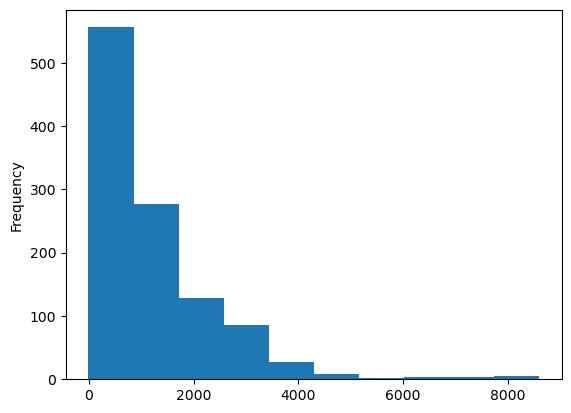

In [18]:
clinical['days_to_last_follow_up'].plot(kind='hist')

<Axes: >

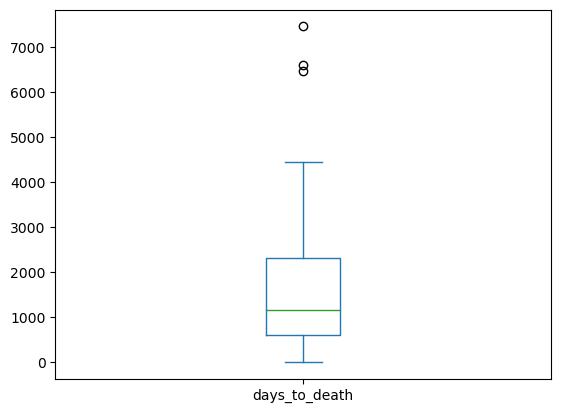

In [19]:
clinical['days_to_death'].plot(kind='box')

<Axes: >

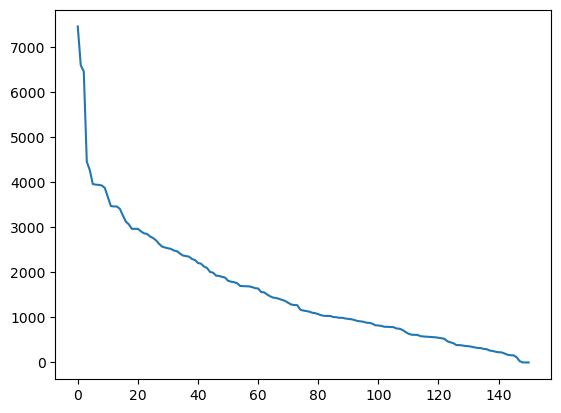

In [20]:
clinical['days_to_death'].sort_values(ascending=False).plot(use_index=False)

<Axes: >

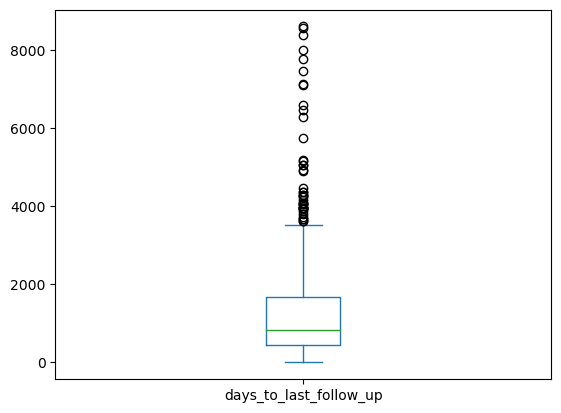

In [21]:
clinical['days_to_last_follow_up'].plot(kind='box')

<Axes: >

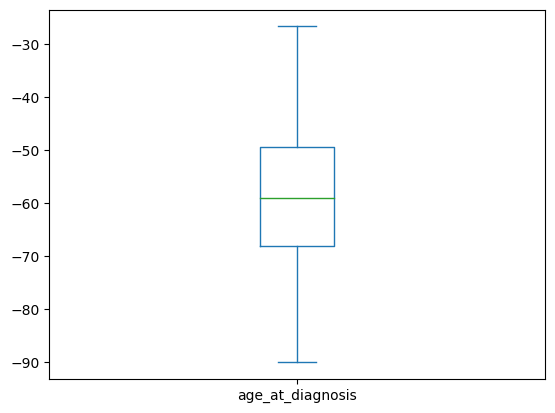

In [22]:
clinical['age_at_diagnosis'].apply(lambda x: -x/365).plot(kind='box')

<Axes: >

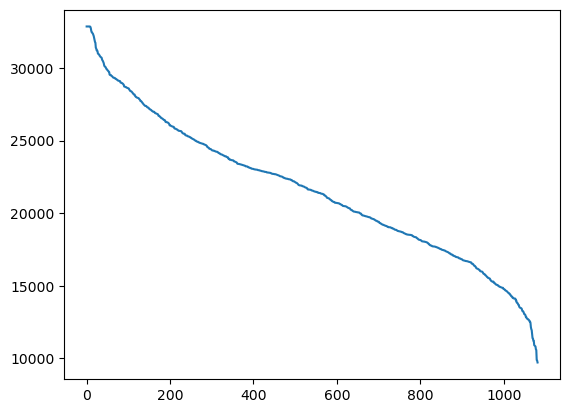

In [23]:
clinical['age_at_diagnosis'].sort_values(ascending=False).plot(use_index=False)

In [24]:
clinical.describe()

,age_at_diagnosis,days_to_death,days_to_last_follow_up
count,1082.000000,151.000000,1096.000000
mean,21586.841035,1584.615894,1232.410584
std,4814.111822,1312.070221,1192.038846
min,9706.000000,0.000000,-7.000000
25%,18028.250000,613.000000,441.750000
50%,21560.500000,1152.000000,821.500000
75%,24868.750000,2322.000000,1673.000000
max,32872.000000,7455.000000,8605.000000


In [25]:
clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098 entries, 0 to 1097
Data columns (total 14 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   submitter_id                                    1098 non-null   object 
 1   synchronous_malignancy                          1088 non-null   object 
 2   ajcc_pathologic_stage                           1086 non-null   object 
 3   age_at_diagnosis                                1082 non-null   float64
 4   prior_malignancy                                1088 non-null   object 
 5   prior_treatment                                 1095 non-null   object 
 6   race                                            1002 non-null   object 
 7   gender                                          1097 non-null   object 
 8   ethnicity                                       931 non-null    object 
 9   vital_status                             

Rename `disease` column as `project_id` and set it as table index.

In [26]:
clinical = clinical.rename(columns={'disease': 'project_id'})

In [27]:
clinical = clinical.set_index('submitter_id')

# Clean up inconsistencies

## Consolidate `race` and `ethnicity`

Whenever `race` value is "white" or missing replace it by `ethnicity` value (if present). Then drop ethnicity column.

In [28]:
race_subset = clinical['race'].isnull()
ethnicity_subset = ~clinical['ethnicity'].isnull()
subset = race_subset & ethnicity_subset
clinical.loc[subset, 'race'] = clinical.loc[subset, 'ethnicity']

In [29]:
race_subset = (clinical['race'] == 'white')
ethnicity_subset = (~clinical['ethnicity'].isnull() &
                    (clinical['ethnicity'] == 'hispanic or latino'))
subset = race_subset & ethnicity_subset
clinical.loc[subset, 'race'] = clinical.loc[subset, 'ethnicity']

In [30]:
clinical.loc[clinical['race'] == 'white', ].shape

(723, 13)

In [31]:
clinical = clinical.drop('ethnicity', axis=1)

## Missing label data

The data show some inconsistencies, such as patients missing `vital_status` information, showing negative `days_to_last_follow_up` values, or missing `days_to_death` values. This is addressed in a few discussions under GitHub issues. [In one of them](https://github.com/BioinformaticsFMRP/TCGAbiolinks/issues/324) someone asked and got the following explanation from the GDC:

> "I have talked to our Clinical Data Scientist and she said that these values can seem strange due to how TCGA and third parties handled patient data. For the negative follow up dates, this can be caused by the pathology report being made at a secondary institution that does the surgery, even though the patient was diagnosed at a local hospital. The larger institution/center eventually reports back the pathologic findings from the surgery, but they never receive follow-up information about the patient. Thus, the days to diagnosis would have been the date the pathology report was signed out, which is always day 0, but the last time the patient was seen relative to that date could have been days or weeks prior to that report being signed out. Basically, we are aware that these negative dates exist, and they are caused by pathology report dates taking priority as day 0. For the patients without days_to_death, this is the case that they knew the patient was deceased, but they were uncertain of the exact date. Thus, when filling out the clinical information they left this intentionally blank.."

Here, I will simply drop these patients from data. I did manually check on the online database the negative values, which matched my downloaded data.

### `vital_status`

In [32]:
print('~~ MISSING DATA ~~')
print()
skip = ['gender', 'race', 'ethnicity', 'prior_malignancy',
        'age_at_diagnosis', 'days_to_death', 'days_to_last_follow_up']

n = clinical.shape[0]

for v in clinical.columns:
    if v not in skip:
        n_missing = sum(clinical[v].isnull())
        print(f'{v}: {n_missing} ({round(n_missing / n * 100, 2)}%)')

~~ MISSING DATA ~~

synchronous_malignancy: 10 (0.91%)
ajcc_pathologic_stage: 12 (1.09%)
prior_treatment: 3 (0.27%)
vital_status: 1 (0.09%)
treatments_pharmaceutical_treatment_or_therapy: 840 (76.5%)
treatments_radiation_treatment_or_therapy: 80 (7.29%)


In [33]:
# Drop patients missing "vital_status" information
subset = ~clinical.vital_status.isna()
clinical = clinical.loc[subset]

### Both duration values

Patients missing both time to death and time to last follow up variables cannot be included in a survival study.

In [34]:
missing_duration_data = clinical[
    clinical['days_to_death'].isna() &
    clinical['days_to_last_follow_up'].isna()]

print('# patients missing both duration columns:', missing_duration_data.shape[0])

# patients missing both duration columns: 1


In [35]:
missing_duration_data.head()

,synchronous_malignancy,ajcc_pathologic_stage,age_at_diagnosis,prior_malignancy,prior_treatment,race,gender,vital_status,days_to_death,days_to_last_follow_up,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy
submitter_id,,,,,,,,,,,,
TCGA-A7-A0DC,No,Stage IA,23294.0,no,No,white,female,Alive,NaN,NaN,yes,yes


In [36]:
# Remove missing data
subset = ~(clinical['days_to_death'].isna() &
           clinical['days_to_last_follow_up'].isna())
clinical = clinical.loc[subset]

In [37]:
clinical.shape

(1096, 12)

### Required duration value

Patients alive at the end of the study require time to last follow up information. Dead patients require time to death information.

In [38]:
print('# patients missing "days_to_last_follow_up" when "vital_status" is "Alive":',
      clinical[(clinical.vital_status == 'Alive') &
               clinical.days_to_last_follow_up.isna()].shape[0])

# patients missing "days_to_last_follow_up" when "vital_status" is "Alive": 0


In [39]:
print('# patients missing "days_to_death" when "vital_status" is "Dead":',
      clinical[(clinical.vital_status == 'Dead') &
               clinical.days_to_death.isna()].shape[0])

# patients missing "days_to_death" when "vital_status" is "Dead": 1


In [40]:
# Remove missing data
subset = ~((clinical.vital_status == 'Dead') &
           clinical.days_to_death.isna())
clinical = clinical.loc[subset]

## Not missing `days_to_last_follow_up` when `vital_status` is "Dead"

In [41]:
print('"Days to death" variable missing for all patients still alive?',
      all(clinical[clinical.vital_status == 'Alive'].days_to_death.isna()))

"Days to death" variable missing for all patients still alive? True


In [42]:
print('"Days to last follow up" variable missing for all dead patients?',
      all(clinical[clinical.vital_status == 'Dead'].days_to_last_follow_up.isna()))

"Days to last follow up" variable missing for all dead patients? False


In [43]:
# Insert "NaN" in "days_to_last_follow_up" when "vital_status" is "Dead" 
subset = clinical.vital_status == 'Dead'
clinical.loc[subset, 'days_to_last_follow_up'] = None

In [44]:
print('"Days to last follow up" variable missing for all dead patients?',
      all(clinical[clinical.vital_status == 'Dead'].days_to_last_follow_up.isna()))

"Days to last follow up" variable missing for all dead patients? True


## Negative durations

In [45]:
clinical[clinical.days_to_last_follow_up < 0]

,synchronous_malignancy,ajcc_pathologic_stage,age_at_diagnosis,prior_malignancy,prior_treatment,race,gender,vital_status,days_to_death,days_to_last_follow_up,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy
submitter_id,,,,,,,,,,,,
TCGA-PL-A8LV,No,Stage IIIB,19746.0,no,No,black or african american,female,Alive,NaN,-7.0,unknown,unknown


In [46]:
# Remove data
subset = ~((clinical.days_to_last_follow_up < 0) &
           (clinical.vital_status == 'Alive'))
clinical = clinical.loc[subset]

In [47]:
clinical.shape

(1094, 12)

# Label data

Collect duration label: `days_to_last_follow_up` and `days_to_death` for live and dead patients, respectively.

In [48]:
def get_duration(vital_status, days_to_death, days_to_last_follow_up):
    if vital_status == 'Dead':
        return days_to_death
    elif vital_status == 'Alive':
        return days_to_last_follow_up
    else:
        print('Found NaN in duration!')

def get_events(vital_status):
    if vital_status in ['1', 'Dead']:
        return 1
    elif vital_status in ['0', 'Alive']:
        return 0
    else:
        print('Found NaN in vital status!')

In [49]:
d = {'submitter_id': clinical.index,
     'time': clinical.apply(
         lambda x: get_duration(x['vital_status'], x['days_to_death'],
                                x['days_to_last_follow_up']), axis=1).values,
     'event': clinical.apply(
         lambda x: get_events(x['vital_status']), axis=1).values}

In [50]:
survival = pd.DataFrame.from_dict(d).astype(
    {'submitter_id': 'object', 'time': 'int64', 'event': 'int64'})

In [51]:
clinical = clinical.join(survival.set_index('submitter_id'))

In [52]:
clinical.head()

,synchronous_malignancy,ajcc_pathologic_stage,age_at_diagnosis,prior_malignancy,prior_treatment,race,gender,vital_status,days_to_death,days_to_last_follow_up,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,time,event
submitter_id,,,,,,,,,,,,,,
TCGA-Z7-A8R6,No,Stage I,16955.0,no,No,white,female,Alive,NaN,3256.0,yes,no,3256,0
TCGA-C8-A1HE,No,Stage IIA,NaN,no,No,asian,female,Alive,NaN,375.0,yes,no,375,0
TCGA-A8-A07B,No,Stage IIA,25475.0,no,No,NaN,female,Alive,NaN,1308.0,no,no,1308,0
TCGA-AC-A2FM,No,Stage IIB,31805.0,no,No,white,female,Dead,792.0,NaN,no,no,792,1
TCGA-B6-A1KF,No,Stage IIB,24891.0,no,No,white,female,Alive,NaN,3088.0,yes,yes,3088,0


# Train-val-test split

Split by patient and stratify by `project_id`.

In [53]:
# Get unique cases with their info
case_info = clinical.groupby(clinical.index).agg({
    'event': 'first',
    'age_at_diagnosis': 'first'
}).reset_index()  # This creates an 'index' column with patient IDs

# Check the structure
print("Case info columns:", case_info.columns.tolist())
print("First few rows:\n", case_info.head())

# If the patient IDs are in a different column name, use that
# The reset_index() should create a column with the index name
patient_id_column = case_info.columns[0]  # Usually the first column after reset_index()
print(f"\nPatient ID column: {patient_id_column}")

# Create age bins for better stratification
case_info['age_bin'] = pd.qcut(case_info['age_at_diagnosis'], q=5, labels=False)
case_info['strat_var'] = case_info['event'].astype(str) + '_' + case_info['age_bin'].astype(str)

# Check the event distribution
print(f"\nTotal patients: {len(case_info)}")
print(f"Events: {case_info['event'].sum()} ({case_info['event'].mean():.2%})")
print(f"Censored: {(~case_info['event'].astype(bool)).sum()}")

# 5-Fold Cross-Validation Setup
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Store fold assignments
fold_assignments = {}

for fold_idx, (train_val_idx, test_idx) in enumerate(skf.split(case_info.index, case_info['strat_var'])):
    
    # Get test cases for this fold (20% of total)
    test_cases = case_info.iloc[test_idx][patient_id_column].values
    
    # Get train+val cases (80% of total)
    train_val_cases = case_info.iloc[train_val_idx]
    
    # Within the 80%, split into train (65% of total) and val (15% of total)
    train_idx, val_idx = train_test_split(
        train_val_idx,  # Use the indices directly
        test_size=0.1875,  # 15/80 = 0.1875
        stratify=case_info.iloc[train_val_idx]['strat_var'],
        random_state=42 + fold_idx
    )
    
    train_cases = case_info.iloc[train_idx][patient_id_column].values
    val_cases = case_info.iloc[val_idx][patient_id_column].values
    
    fold_assignments[fold_idx] = {
        'train': train_cases,
        'val': val_cases,
        'test': test_cases
    }

Case info columns: ['submitter_id', 'event', 'age_at_diagnosis']
First few rows:
    submitter_id  event  age_at_diagnosis
0  TCGA-3C-AAAU      0           20211.0
1  TCGA-3C-AALI      0           18538.0
2  TCGA-3C-AALJ      0           22848.0
3  TCGA-3C-AALK      0           19074.0
4  TCGA-4H-AAAK      0           18371.0

Patient ID column: submitter_id

Total patients: 1094
Events: 151 (13.80%)
Censored: 943


In [54]:
  # Print statistics for this fold
print(f"\nFold {fold_idx + 1}:")
print(f"  Train: {len(train_cases)} patients ({len(train_cases)/len(case_info)*100:.1f}%)")
print(f"  Val: {len(val_cases)} patients ({len(val_cases)/len(case_info)*100:.1f}%)")
print(f"  Test: {len(test_cases)} patients ({len(test_cases)/len(case_info)*100:.1f}%)")
    
# Check event rates
train_events = case_info[case_info[patient_id_column].isin(train_cases)]['event'].mean()
val_events = case_info[case_info[patient_id_column].isin(val_cases)]['event'].mean()
test_events = case_info[case_info[patient_id_column].isin(test_cases)]['event'].mean()
    
print(f"  Event rates - Train: {train_events:.2%}, Val: {val_events:.2%}, Test: {test_events:.2%}")


Fold 5:
  Train: 711 patients (65.0%)
  Val: 165 patients (15.1%)
  Test: 218 patients (19.9%)
  Event rates - Train: 13.78%, Val: 13.94%, Test: 13.76%


In [55]:
clinical.head()

,synchronous_malignancy,ajcc_pathologic_stage,age_at_diagnosis,prior_malignancy,prior_treatment,race,gender,vital_status,days_to_death,days_to_last_follow_up,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,time,event
submitter_id,,,,,,,,,,,,,,
TCGA-Z7-A8R6,No,Stage I,16955.0,no,No,white,female,Alive,NaN,3256.0,yes,no,3256,0
TCGA-C8-A1HE,No,Stage IIA,NaN,no,No,asian,female,Alive,NaN,375.0,yes,no,375,0
TCGA-A8-A07B,No,Stage IIA,25475.0,no,No,NaN,female,Alive,NaN,1308.0,no,no,1308,0
TCGA-AC-A2FM,No,Stage IIB,31805.0,no,No,white,female,Dead,792.0,NaN,no,no,792,1
TCGA-B6-A1KF,No,Stage IIB,24891.0,no,No,white,female,Alive,NaN,3088.0,yes,yes,3088,0


In [56]:
# Function to create dataset for a specific fold
def create_fold_dataset(clinical_df, fold_num):
    """Create train/val/test split for a specific fold"""
    clinical_copy = clinical_df.copy()
    clinical_copy['group'] = 'Missing'
    
    assignments = fold_assignments[fold_num]
    clinical_copy.loc[clinical_copy.index.isin(assignments['train']), 'group'] = 'train'
    clinical_copy.loc[clinical_copy.index.isin(assignments['val']), 'group'] = 'val'  
    clinical_copy.loc[clinical_copy.index.isin(assignments['test']), 'group'] = 'test'
    
    return clinical_copy

# For single experiment using fold 0
clinical_fold0 = create_fold_dataset(clinical, fold_num=0)
clinical_fold0['time'] = clinical_fold0['time'] / 365

In [57]:
# Verify the split
print("\n" + "="*50)
print("Fold 0 Summary (for single experiment):")
print("="*50)
print("\nGroup distribution:")
print(clinical_fold0['group'].value_counts())
print("\nEvent rates by group:")
print(clinical_fold0.groupby('group')['event'].mean())
print("\nAge statistics by group:")
print(clinical_fold0.groupby('group')['age_at_diagnosis'].describe()[['mean', 'std']])


Fold 0 Summary (for single experiment):

Group distribution:
group
train    710
test     219
val      165
Name: count, dtype: int64

Event rates by group:
group
test     0.136986
train    0.138028
val      0.139394
Name: event, dtype: float64

Age statistics by group:
               mean          std
group                           
test   21465.356481  4675.130954
train  21609.001429  4859.261948
val    21679.392638  4855.645501


## Survival curves

Plot Kaplan-Meier survival function.

Text(0, 0.5, 'Survival probability')

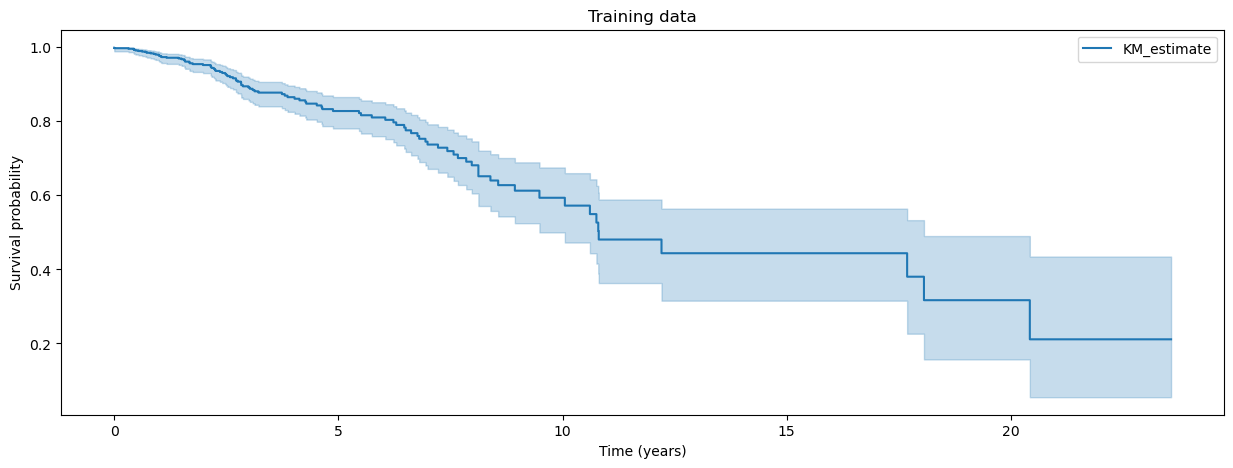

In [58]:
import matplotlib.pyplot as plt
#Extract each group from clinical_fold0
train = clinical_fold0[clinical_fold0['group'] == 'train']
val = clinical_fold0[clinical_fold0['group'] == 'val']
test = clinical_fold0[clinical_fold0['group'] == 'test']

# Create figure
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

# Plot training data
kmf = KaplanMeierFitter()
kmf.fit(train['time'], event_observed=train['event'])
ax1 = kmf.plot(title='Training data')
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Survival probability')

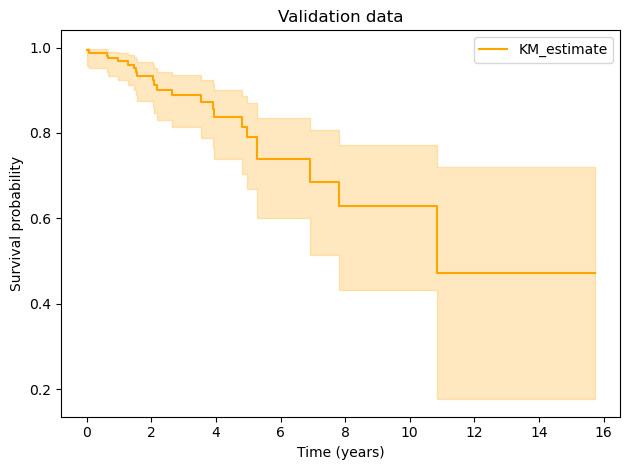

In [59]:
# Plot validation data
kmf.fit(val['time'], event_observed=val['event'])
ax2 = kmf.plot(title='Validation data', color='orange')
ax2.set_xlabel('Time (years)')
ax2.set_ylabel('Survival probability')
plt.tight_layout()

Text(0, 0.5, 'Survival probability')

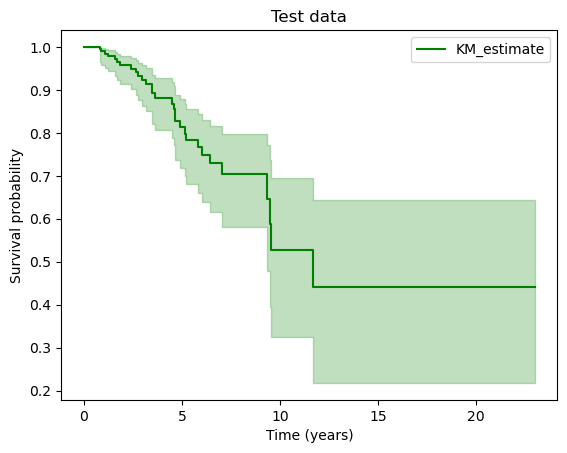

In [60]:
# Plot test data
kmf.fit(test['time'], event_observed=test['event'])
ax3 = kmf.plot(title='Test data', color='green')
ax3.set_xlabel('Time (years)')
ax3.set_ylabel('Survival probability')


# Save clinical data to file

To use in the visualization of the features learned by the model.

In [61]:
clinical.head()

,synchronous_malignancy,ajcc_pathologic_stage,age_at_diagnosis,prior_malignancy,prior_treatment,race,gender,vital_status,days_to_death,days_to_last_follow_up,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,time,event
submitter_id,,,,,,,,,,,,,,
TCGA-Z7-A8R6,No,Stage I,16955.0,no,No,white,female,Alive,NaN,3256.0,yes,no,3256,0
TCGA-C8-A1HE,No,Stage IIA,NaN,no,No,asian,female,Alive,NaN,375.0,yes,no,375,0
TCGA-A8-A07B,No,Stage IIA,25475.0,no,No,NaN,female,Alive,NaN,1308.0,no,no,1308,0
TCGA-AC-A2FM,No,Stage IIB,31805.0,no,No,white,female,Dead,792.0,NaN,no,no,792,1
TCGA-B6-A1KF,No,Stage IIB,24891.0,no,No,white,female,Alive,NaN,3088.0,yes,yes,3088,0


In [62]:
clinical_fold0.to_csv('clinical_data.tsv', sep='\t')

# Input missing values

* Input missing continuous data with median value.
* Leave categorical features unchanged, to treat missing data as its own category.

In [63]:
print('~~ MISSING DATA ~~')
print()
# Check missing values BEFORE imputation
skip = ['days_to_death', 'days_to_last_follow_up', 'group', 'time', 'event']
print('~~ MISSING DATA BEFORE IMPUTATION ~~\n')
n = clinical_fold0.shape[0]
features_with_missing = []
for v in clinical_fold0.columns:
    if v not in skip:
        n_missing = sum(clinical_fold0[v].isnull())
        if n_missing > 0:
            print(f'{v}: {n_missing} ({round(n_missing / n * 100, 2)}%)')
            features_with_missing.append(v)

~~ MISSING DATA ~~

~~ MISSING DATA BEFORE IMPUTATION ~~

synchronous_malignancy: 9 (0.82%)
ajcc_pathologic_stage: 11 (1.01%)
age_at_diagnosis: 15 (1.37%)
prior_malignancy: 9 (0.82%)
prior_treatment: 2 (0.18%)
race: 91 (8.32%)
treatments_pharmaceutical_treatment_or_therapy: 838 (76.6%)
treatments_radiation_treatment_or_therapy: 79 (7.22%)


In [64]:
# Define the imputation function
def input_missing_values(feature, df):
    """Impute missing values using training set statistics"""
    train_subset = df.loc[df['group'] == 'train', feature]
    try:
        # For continuous features, use median
        input_value = train_subset.median()
        print(f'Median "{feature}": {input_value}')
    except TypeError:
        # For categorical features, use mode
        input_value = train_subset.mode().iloc[0]
        print(f'Mode "{feature}": {input_value}')
    
    df[feature].fillna(input_value, inplace=True)
    return df

In [65]:
# Impute missing values
print('\n~~ IMPUTATION VALUES (from training set) ~~\n')
for feature in features_with_missing:
    clinical_fold0 = input_missing_values(feature=feature, df=clinical_fold0)

# Verify no missing data remains
print('\n~~ MISSING DATA AFTER IMPUTATION ~~\n')
n = clinical_fold0.shape[0]
any_missing = False
for v in clinical_fold0.columns:
    if v not in skip:
        n_missing = sum(clinical_fold0[v].isnull())
        if n_missing > 0:
            print(f'{v}: {n_missing} ({round(n_missing / n * 100, 2)}%)')
            any_missing = True

if not any_missing:
    print("✅ No missing values remain!")


~~ IMPUTATION VALUES (from training set) ~~

Mode "synchronous_malignancy": No
Mode "ajcc_pathologic_stage": Stage IIA
Median "age_at_diagnosis": 21519.0
Mode "prior_malignancy": no
Mode "prior_treatment": No
Mode "race": white
Mode "treatments_pharmaceutical_treatment_or_therapy": no
Mode "treatments_radiation_treatment_or_therapy": yes

~~ MISSING DATA AFTER IMPUTATION ~~

✅ No missing values remain!


# Scale continuous variables

In [66]:
clinical_fold0.columns

Index(['synchronous_malignancy', 'ajcc_pathologic_stage', 'age_at_diagnosis',
       'prior_malignancy', 'prior_treatment', 'race', 'gender', 'vital_status',
       'days_to_death', 'days_to_last_follow_up',
       'treatments_pharmaceutical_treatment_or_therapy',
       'treatments_radiation_treatment_or_therapy', 'time', 'event', 'group'],
      dtype='object')

In [67]:
skip

['days_to_death', 'days_to_last_follow_up', 'group', 'time', 'event']

In [68]:
continuous = ['age_at_diagnosis']

In [69]:
def min_max_scale(data, features):
    """Scale continuous features using training set statistics"""
    # Fit scaler on training data only
    train_data = data.loc[data['group'] == 'train', features]
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    
    # Apply to all groups
    for group in ['train', 'val', 'test']:
        group_indices = data['group'] == group
        data.loc[group_indices, features] = scaler.transform(
            data.loc[group_indices, features]
        )
    
    return data, scaler

In [70]:
# Apply scaling
clinical_fold0, age_scaler = min_max_scale(data=clinical_fold0, features=continuous)

In [71]:
# Verify scaling
print("Age at diagnosis statistics after scaling:")
print(clinical_fold0.groupby('group')['age_at_diagnosis'].describe())

Age at diagnosis statistics after scaling:
       count      mean       std       min       25%       50%       75%  \
group                                                                      
test   219.0  0.507644  0.200417  0.037037  0.362190  0.514375  0.652508   
train  710.0  0.513759  0.208274  0.000000  0.359665  0.509928  0.652432   
val    165.0  0.516768  0.208322  0.007209  0.368255  0.510576  0.654882   

            max  
group            
test   0.987525  
train  1.000000  
val    1.000000  


In [72]:
# Check that training set is properly scaled to [0, 1]
train_stats = clinical_fold0[clinical_fold0['group'] == 'train']['age_at_diagnosis'].describe()
print(f"\nTraining set range: [{train_stats['min']:.3f}, {train_stats['max']:.3f}]")
print("✅ Should be [0.000, 1.000] for training set")


Training set range: [0.000, 1.000]
✅ Should be [0.000, 1.000] for training set


In [73]:
clinical_fold0.head()

,synchronous_malignancy,ajcc_pathologic_stage,age_at_diagnosis,prior_malignancy,prior_treatment,race,gender,vital_status,days_to_death,days_to_last_follow_up,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,time,event,group
submitter_id,,,,,,,,,,,,,,,
TCGA-Z7-A8R6,No,Stage I,0.312915,no,No,white,female,Alive,NaN,3256.0,yes,no,8.920548,0,test
TCGA-C8-A1HE,No,Stage IIA,0.509928,no,No,asian,female,Alive,NaN,375.0,yes,no,1.027397,0,test
TCGA-A8-A07B,No,Stage IIA,0.680696,no,No,white,female,Alive,NaN,1308.0,no,no,3.583562,0,train
TCGA-AC-A2FM,No,Stage IIB,0.953941,no,No,white,female,Dead,792.0,NaN,no,no,2.169863,1,train
TCGA-B6-A1KF,No,Stage IIB,0.655486,no,No,white,female,Alive,NaN,3088.0,yes,yes,8.460274,0,train


# Encode categorical variables

Encode labels (with a value between 0 and n_classes-1) to use with categorical embeddings.

In [74]:
# Drop unnecessary columns
clinical_fold0 = clinical_fold0.drop(columns=['days_to_death', 'days_to_last_follow_up', 'vital_status'])

In [75]:
clinical_fold0.columns

Index(['synchronous_malignancy', 'ajcc_pathologic_stage', 'age_at_diagnosis',
       'prior_malignancy', 'prior_treatment', 'race', 'gender',
       'treatments_pharmaceutical_treatment_or_therapy',
       'treatments_radiation_treatment_or_therapy', 'time', 'event', 'group'],
      dtype='object')

In [76]:
skip = ['time', 'event', 'group']
skip

['time', 'event', 'group']

In [77]:
continuous

['age_at_diagnosis']

In [78]:
len(clinical_fold0.columns)

12

In [79]:
# Reorder columns
categorical = ['gender', 'race', 'prior_treatment', 'prior_malignancy', 'synchronous_malignancy',
               'treatments_pharmaceutical_treatment_or_therapy',
               'treatments_radiation_treatment_or_therapy', 'ajcc_pathologic_stage'
               ]

# Verify all categorical features exist
available_categorical = [col for col in categorical if col in clinical_fold0.columns]
if len(available_categorical) != len(categorical):
    missing = set(categorical) - set(available_categorical)
    print(f"Warning: Missing categorical features: {missing}")
    categorical = available_categorical
    
clinical_fold0 = clinical_fold0[categorical + continuous + skip]

In [80]:
len(clinical_fold0.columns)

12

In [81]:
# Save a copy of the table to allow inclusion of unencoded "project_id" in the labels table
survival = clinical_fold0.copy()

In [82]:
# Encode categorical variables
split_groups = ['train', 'val', 'test']
label_encoders = {}

# Convert to string and fit encoders on training data
for feature in categorical:
    clinical_fold0[feature] = clinical_fold0[feature].astype(str)
    label_encoders[feature] = LabelEncoder()
    
    # Fit only on training data
    train_values = clinical_fold0.loc[clinical_fold0['group'] == 'train', feature]
    label_encoders[feature].fit(train_values)
    
    # Print unique values from training set
    n_classes = len(label_encoders[feature].classes_)
    print(f"{feature}: {n_classes} unique values in training set")

# Transform all groups
for group in split_groups:
    for feature in categorical:
        try:
            clinical_fold0.loc[
                clinical_fold0['group'] == group, feature] = label_encoders[feature].transform(
                clinical_fold0.loc[clinical_fold0['group'] == group, feature])
        except ValueError as e:
            print(f"Warning: New category in {group} set for feature {feature}")
            # Handle unknown categories by assigning them to a default value
            unknown_mask = ~clinical_fold0.loc[clinical_fold0['group'] == group, feature].isin(
                label_encoders[feature].classes_)
            if unknown_mask.any():
                print(f"  Found {unknown_mask.sum()} unknown values, assigning to category 0")
                clinical_fold0.loc[
                    (clinical_fold0['group'] == group) & unknown_mask, feature] = 0

gender: 2 unique values in training set
race: 6 unique values in training set
prior_treatment: 2 unique values in training set
prior_malignancy: 2 unique values in training set
synchronous_malignancy: 2 unique values in training set
treatments_pharmaceutical_treatment_or_therapy: 3 unique values in training set
treatments_radiation_treatment_or_therapy: 3 unique values in training set
ajcc_pathologic_stage: 12 unique values in training set


The embedding dimensions (in a list of two-tuples) are calculated in the next cell: number of unique values paired with the embedding dimension for each categorical feature.

The embedding size is determined according to the rule-of-thumb from the Fast.ai course.

In [83]:
# Calculate embedding dimensions
categorical_dims = [int(clinical_fold0[col].nunique()) for col in categorical]
embedding_dims = [(x, min(50, (x + 1) // 2)) for x in categorical_dims]

# Display embedding dimensions
print('\nFeature                                            Levels   Embedding dims')
print('-------                                            ------   --------------')
for i, feat in enumerate(categorical):
    print(f"{feat:<50} {embedding_dims[i][0]:<8} {embedding_dims[i][1]}")

# Save label encoders for later use
import joblib
joblib.dump(label_encoders, f'{DATA_LOCATION}/label_encoders_fold0.pkl')
print(f"\n✅ Saved label encoders to {DATA_LOCATION}/label_encoders_fold0.pkl")

# Verify the encoding worked
print("\nSample of encoded data:")
print(clinical_fold0.head())

# Check data types
print("\nData types after encoding:")
for col in clinical_fold0.columns:
    print(f"{col}: {clinical_fold0[col].dtype}")


Feature                                            Levels   Embedding dims
-------                                            ------   --------------
gender                                             2        1
race                                               6        3
prior_treatment                                    2        1
prior_malignancy                                   2        1
synchronous_malignancy                             2        1
treatments_pharmaceutical_treatment_or_therapy     3        2
treatments_radiation_treatment_or_therapy          3        2
ajcc_pathologic_stage                              12       6

✅ Saved label encoders to /mnt/data/Processed_Data/Clinical/label_encoders_fold0.pkl

Sample of encoded data:
             gender race prior_treatment prior_malignancy  \
submitter_id                                                
TCGA-Z7-A8R6      0    5               0                0   
TCGA-C8-A1HE      0    1               0                0  

In [84]:


# The issue: LabelEncoder transform returns numpy array, but assignment might not be working
# Fix: Ensure proper integer conversion after encoding

for feature in categorical:
    # Convert to numeric, forcing any remaining strings to NaN
    clinical_fold0[feature] = pd.to_numeric(clinical_fold0[feature], errors='coerce')
    
    # Check for any NaN values that resulted from conversion
    nan_count = clinical_fold0[feature].isna().sum()
    if nan_count > 0:
        print(f"WARNING: {feature} has {nan_count} values that couldn't be converted to numeric")
    
    # Convert to integer type
    clinical_fold0[feature] = clinical_fold0[feature].fillna(0).astype(int)

# Verify the fix
print("\nAfter conversion:")
for feature in categorical:
    print(f"{feature}: {clinical_fold0[feature].dtype}")
    print(f"  Values: {sorted(clinical_fold0[feature].unique())}")


After conversion:
gender: int64
  Values: [0, 1]
race: int64
  Values: [0, 1, 2, 3, 4, 5]
prior_treatment: int64
  Values: [0, 1]
prior_malignancy: int64
  Values: [0, 1]
synchronous_malignancy: int64
  Values: [0, 1]
treatments_pharmaceutical_treatment_or_therapy: int64
  Values: [0, 1, 2]
treatments_radiation_treatment_or_therapy: int64
  Values: [0, 1, 2]
ajcc_pathologic_stage: int64
  Values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


# Save patient data to files

## Survival labels

In [85]:
survival['submitter_id'] = survival.index
survival = survival.reset_index(drop=True)

label_columns = ['submitter_id', 'time', 'event', 'group']
survival = survival.loc[:, label_columns]

In [86]:
survival.head()

,submitter_id,time,event,group
0,TCGA-Z7-A8R6,8.920548,0,test
1,TCGA-C8-A1HE,1.027397,0,test
2,TCGA-A8-A07B,3.583562,0,train
3,TCGA-AC-A2FM,2.169863,1,train
4,TCGA-B6-A1KF,8.460274,0,train


In [87]:
survival.to_csv('/app/data/labels.tsv', sep='\t', index=False)

## Clinical data

Save preprocessed clinical data as individual patient files (to use with PyTorch dataset).

In [88]:
# Final verification
print("✅ Encoding is correct!")
print("\nSample patient decoded:")
patient = clinical_fold0.iloc[0]
for feature in categorical:
    encoded_val = int(patient[feature])  # Convert to Python int
    original_val = label_encoders[feature].classes_[encoded_val]
    print(f"{feature}: {encoded_val} = '{original_val}'")

# Alternative safer version with error handling
print("\n" + "="*50)
print("Complete verification for first 3 patients:")
print("="*50)

for idx in range(min(3, len(clinical_fold0))):
    patient_id = clinical_fold0.index[idx]
    print(f"\nPatient {patient_id}:")
    patient = clinical_fold0.iloc[idx]
    
    for feature in categorical:
        try:
            encoded_val = int(patient[feature])
            if 0 <= encoded_val < len(label_encoders[feature].classes_):
                original_val = label_encoders[feature].classes_[encoded_val]
                print(f"  {feature}: {encoded_val} = '{original_val}'")
            else:
                print(f"  {feature}: {encoded_val} = OUT OF RANGE")
        except Exception as e:
            print(f"  {feature}: Error - {e}")


# Quick summary
print(f"\nFinal dataset summary:")
print(f"Shape: {clinical_fold0.shape}")
print(f"Features: {list(clinical_fold0.columns)}")
print(f"Train: {(clinical_fold0['group'] == 'train').sum()} patients")
print(f"Val: {(clinical_fold0['group'] == 'val').sum()} patients")
print(f"Test: {(clinical_fold0['group'] == 'test').sum()} patients")

✅ Encoding is correct!

Sample patient decoded:
gender: 0 = 'female'
race: 5 = 'white'
prior_treatment: 0 = 'No'
prior_malignancy: 0 = 'no'
synchronous_malignancy: 0 = 'No'
treatments_pharmaceutical_treatment_or_therapy: 2 = 'yes'
treatments_radiation_treatment_or_therapy: 0 = 'no'
ajcc_pathologic_stage: 0 = 'Stage I'

Complete verification for first 3 patients:

Patient TCGA-Z7-A8R6:
  gender: 0 = 'female'
  race: 5 = 'white'
  prior_treatment: 0 = 'No'
  prior_malignancy: 0 = 'no'
  synchronous_malignancy: 0 = 'No'
  treatments_pharmaceutical_treatment_or_therapy: 2 = 'yes'
  treatments_radiation_treatment_or_therapy: 0 = 'no'
  ajcc_pathologic_stage: 0 = 'Stage I'

Patient TCGA-C8-A1HE:
  gender: 0 = 'female'
  race: 1 = 'asian'
  prior_treatment: 0 = 'No'
  prior_malignancy: 0 = 'no'
  synchronous_malignancy: 0 = 'No'
  treatments_pharmaceutical_treatment_or_therapy: 2 = 'yes'
  treatments_radiation_treatment_or_therapy: 0 = 'no'
  ajcc_pathologic_stage: 4 = 'Stage IIA'

Patient TC

In [89]:
skip

['time', 'event', 'group']

In [90]:
clinical_fold0 = clinical_fold0[categorical + continuous]

In [91]:
clinical_fold0.head()

,gender,race,prior_treatment,prior_malignancy,synchronous_malignancy,treatments_pharmaceutical_treatment_or_therapy,treatments_radiation_treatment_or_therapy,ajcc_pathologic_stage,age_at_diagnosis
submitter_id,,,,,,,,,
TCGA-Z7-A8R6,0,5,0,0,0,2,0,0,0.312915
TCGA-C8-A1HE,0,1,0,0,0,2,0,4,0.509928
TCGA-A8-A07B,0,5,0,0,0,0,0,4,0.680696
TCGA-AC-A2FM,0,5,0,0,0,0,0,5,0.953941
TCGA-B6-A1KF,0,5,0,0,0,2,2,5,0.655486


In [92]:
# Let's properly trace the encoding process
patient_id = 'TCGA-Z7-A8R6'

print(f"Tracing patient {patient_id}:")

# The value in clinical_fold0 is ALREADY encoded
encoded_race = clinical_fold0[clinical_fold0.index == patient_id]['race'].iloc[0]
print(f"Encoded race value: {encoded_race}")

# Check what original values map to what encoded values
race_encoder = label_encoders['race'] 
print(f"\nRace encoder mapping:")
print(f"Original values (strings): {race_encoder.classes_}")
print(f"Maps to: {list(range(len(race_encoder.classes_)))}")

# Create reverse mapping
race_mapping = dict(zip(range(len(race_encoder.classes_)), race_encoder.classes_))
print(f"\nReverse mapping:")
for encoded, original in race_mapping.items():
    print(f"  {encoded} ← '{original}'")

# So encoded race=5 came from original value:
original_race_value = race_mapping[encoded_race]
print(f"\nPatient's encoded race {encoded_race} came from original value: '{original_race_value}'")

# To see all the mappings for all features:
print("\n" + "="*50)
print("ALL FEATURE MAPPINGS:")
print("="*50)

for feature in categorical:
    encoder = label_encoders[feature]
    print(f"\n{feature}:")
    for i, original_val in enumerate(encoder.classes_):
        print(f"  '{original_val}' → {i}")


Tracing patient TCGA-Z7-A8R6:
Encoded race value: 5

Race encoder mapping:
Original values (strings): ['american indian or alaska native' 'asian' 'black or african american'
 'hispanic or latino' 'not hispanic or latino' 'white']
Maps to: [0, 1, 2, 3, 4, 5]

Reverse mapping:
  0 ← 'american indian or alaska native'
  1 ← 'asian'
  2 ← 'black or african american'
  3 ← 'hispanic or latino'
  4 ← 'not hispanic or latino'
  5 ← 'white'

Patient's encoded race 5 came from original value: 'white'

ALL FEATURE MAPPINGS:

gender:
  'female' → 0
  'male' → 1

race:
  'american indian or alaska native' → 0
  'asian' → 1
  'black or african american' → 2
  'hispanic or latino' → 3
  'not hispanic or latino' → 4
  'white' → 5

prior_treatment:
  'No' → 0
  'Yes' → 1

prior_malignancy:
  'no' → 0
  'yes' → 1

synchronous_malignancy:
  'No' → 0
  'Yes' → 1

treatments_pharmaceutical_treatment_or_therapy:
  'no' → 0
  'unknown' → 1
  'yes' → 2

treatments_radiation_treatment_or_therapy:
  'no' → 0
 

In [93]:
def table_to_patient_files(table, dir_path, round_digits=4):
    n = len(table)
    
    i = 0

    for index, row in table.iterrows():
        print('\r' + f'Save data to files: {str(i + 1)}/{n}', end='')
        i+= 1

        target_file = os.path.join(dir_path, str(index) + '.tsv')
        
        with open(target_file, 'w') as f:
            if round_digits is not None:
                f.write('\n'.join(str(round(value, round_digits)) for value in row.values))
            else:
                f.write('\n'.join(str(value) for value in row.values))

    print()
    print()

In [94]:
%%time

table_to_patient_files(clinical_fold0, dir_path=DATA_LOCATION, round_digits=None)

Save data to files: 1094/1094

CPU times: user 273 ms, sys: 299 ms, total: 571 ms
Wall time: 7.8 s


# Watermark <a class='tocSkip'></a>

In [287]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

pandas    : 2.0.3
sklearn   : 0.0.post12
joblib    : 1.4.2
lifelines : 0.27.8
matplotlib: 3.7.3

Python implementation: CPython
Python version       : 3.8.20
IPython version      : 8.12.2


Last updated: Sat Jun 21 2025



[Top of the page](#Top)